# 理論

複数時点での介入を扱うモデルを以下のように定式化する。

$$
y_t = \beta_0 + \beta_1 t + \sum_{p=1}^{P}\gamma_p D_{p, t} + \sum_{p=1}^{P} \delta_p \Delta_{p,t} + \sum_{j=1}^{J} \eta_j X_{j,t} + \epsilon_t
$$

ここで、各変数は以下のように定義される。
1. $y_t$:時点$t$におけるアウトカム変数
2. $t$:時点を表す連続変数
3. $D_{p,t}$:時点$t$における介入$p$のダミー変数
  a. 介入期間中は1、介入前後は0となる。
4. $\Delta_{p,t}$:介入の経過期間を表す変数
  a. 介入開始時点で1、以降は1ずつ増加する。
5. $X_{j,t}$:時点$t$における共変量
6. $\epsilon_t$:誤差項、独立同分布で平均0、分散$\sigma^2$を持つと仮定

パラメータについて、以下のように解釈される。
1. $\beta_0$:切片
2. $\beta_1$:時間の傾き
3. $\gamma_p$:介入$p$の直後のレベル変化
4. $\delta_p$:介入$p$のトレンドの変化
5. $\eta_j$:共変量$j$の効果

References:
- [石山 隼, 藤原 大悟, 片島 健博, 泉谷 知範, 分割時系列デザインに基づく低頻度繰り返し介入の効果推定手法, 人工知能学会全国大会論文集, 2024,](https://www.jstage.jst.go.jp/article/pjsai/JSAI2024/0/JSAI2024_4Xin271/_pdf/-char/ja)
- [Turner, S.L., Karahalios, A., Forbes, A.B. et al. Comparison of six statistical methods for interrupted time series studies: empirical evaluation of 190 published series. BMC Med Res Methodol 21, 134 (2021).](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-021-01306-w)

In [46]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import matplotlib.pyplot as plt

In [47]:
cigar = sm.datasets.get_rdataset("Cigar", "Ecdat").data
cigar.describe()

,state,year,price,pop,pop16,cpi,ndi,sales,pimin
count,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,26.826087,77.500000,68.699928,4537.113188,3366.616087,73.596667,7525.023022,123.950870,62.899275
std,14.480570,8.658579,41.986261,4828.836452,3641.847150,36.529330,4747.858744,30.991047,38.323126
min,1.000000,63.000000,23.400000,319.000000,215.200000,30.600000,1322.572977,53.400000,23.400000
25%,15.000000,70.000000,34.775000,1053.000000,781.175000,38.800000,3327.869133,107.900000,31.975000
50%,26.500000,77.500000,52.300000,3174.000000,2315.300000,62.900000,6281.200808,121.200000,46.400000
75%,40.000000,85.000000,98.100000,5280.250000,3914.325000,107.600000,11024.109942,133.200000,90.500000
max,51.000000,92.000000,201.900000,30703.300000,22920.000000,140.300000,23074.000000,297.900000,178.500000


In [48]:
cigar['state'].unique()

array([ 1,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [49]:
state = [3,5]
timestamp = [75, 80, 85]

In [50]:
# 複数時点の介入を想定したITSモデルの構築
cigar_pp = cigar.copy()
for i, event in enumerate(timestamp):
    cigar_pp[f'T_{i+1}'] = (cigar_pp['year'] == event).astype(int)



In [51]:
cigar_pp['D_1'] = (
  (cigar_pp['year']>=timestamp[0]) & (cigar_pp['year']<timestamp[1])
  ).astype(int)
cigar_pp['D_2'] = (
  (cigar_pp['year']>=timestamp[1]) & (cigar_pp['year']<timestamp[2])
  ).astype(int)
cigar_pp['D_3'] = (
  cigar_pp['year']>=timestamp[2]
  ).astype(int)

In [52]:

cigar_pp['timedelta_1'] = cigar_pp[['state', 'D_1']].groupby('state').cumsum()
cigar_pp['timedelta_2'] = cigar_pp[['state', 'D_2']].groupby('state').cumsum()
cigar_pp['timedelta_3'] = cigar_pp[['state', 'D_3']].groupby('state').cumsum()

cigar_pp.loc[cigar_pp['D_1']!=1,'timedelta_1'] = 0
cigar_pp.loc[cigar_pp['D_2']!=1,'timedelta_2'] = 0
cigar_pp.loc[cigar_pp['D_3']!=1,'timedelta_3'] = 0  

In [53]:
cigar_pp.head(30)

,state,year,price,pop,pop16,cpi,ndi,sales,pimin,T_1,T_2,T_3,D_1,D_2,D_3,timedelta_1,timedelta_2,timedelta_3
0,1,63,28.6,3383.0,2236.5,30.6,1558.304530,93.9,26.1,0,0,0,0,0,0,0,0,0
1,1,64,29.8,3431.0,2276.7,31.0,1684.073202,95.4,27.5,0,0,0,0,0,0,0,0,0
2,1,65,29.8,3486.0,2327.5,31.5,1809.841875,98.5,28.9,0,0,0,0,0,0,0,0,0
3,1,66,31.5,3524.0,2369.7,32.4,1915.160357,96.4,29.5,0,0,0,0,0,0,0,0,0
4,1,67,31.6,3533.0,2393.7,33.4,2023.546368,95.5,29.6,0,0,0,0,0,0,0,0,0
5,1,68,35.6,3522.0,2405.2,34.8,2202.485536,88.4,32.0,0,0,0,0,0,0,0,0,0
6,1,69,36.6,3531.0,2411.9,36.7,2377.334666,90.1,32.8,0,0,0,0,0,0,0,0,0
7,1,70,39.6,3444.0,2394.6,38.8,2591.039159,89.8,34.3,0,0,0,0,0,0,0,0,0
8,1,71,42.7,3481.0,2443.5,40.5,2785.315971,95.4,35.8,0,0,0,0,0,0,0,0,0
9,1,72,42.3,3511.0,2484.7,41.8,3034.808297,101.1,37.4,0,0,0,0,0,0,0,0,0


In [54]:
usecols = ['state','year','price', 'pop', 'D_1', 'D_2', 'D_3', 'timedelta_1', 'timedelta_2', 'timedelta_3', 'sales']
cigar_model = cigar_pp.loc[(cigar_pp['state'].isin(state)) & (cigar_pp['year']>=65),usecols]
cigar_model['t'] = cigar_model[['state', 'year']].groupby('state').cumcount() + 1

In [55]:
cigar_model.head()

,state,year,price,pop,D_1,D_2,D_3,timedelta_1,timedelta_2,timedelta_3,sales,t
32,3,65,24.2,1575.0,0,0,0,0,0,0,123.2,1
33,3,66,29.6,1609.0,0,0,0,0,0,0,113.9,2
34,3,67,29.2,1637.0,0,0,0,0,0,0,117.1,3
35,3,68,31.3,1667.0,0,0,0,0,0,0,115.6,4
36,3,69,36.1,1693.0,0,0,0,0,0,0,113.8,5


In [56]:
X = sm.add_constant(cigar_model.drop(['sales', 'year'], axis=1))
y = cigar_model['sales']

model = sm.OLS(y, X)

reg_res = model.fit(cov_type='HAC', cov_kwds={'maxlags':3})
print(reg_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     460.7
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           7.39e-42
Time:                        13:29:35   Log-Likelihood:                -158.74
No. Observations:                  56   AIC:                             339.5
Df Residuals:                      45   BIC:                             361.8
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          50.2651     16.008      3.140      

In [57]:
X_counterfactual = X.copy()
tozero_cols = ['D_1', 'D_2', 'D_3', 'timedelta_1', 'timedelta_2', 'timedelta_3']
X_counterfactual[tozero_cols] = 0
y_counterfactual = reg_res.get_prediction(X_counterfactual).predicted_mean

In [59]:
cigar_plot = cigar_model.copy()
cigar_plot['y_counterfactual'] = y_counterfactual
cigar_plot['y_pred_mean'] = y_pred_mean
cigar_plot['y_pred_ci_lower'] = y_pred_ci_lower
cigar_plot['y_pred_ci_upper'] = y_pred_ci_upper

In [58]:
y_pred_info = reg_res.get_prediction(X).summary_frame(alpha=0.05)
y_pred_mean = y_pred_info['mean']
y_pred_ci_lower = y_pred_info['obs_ci_lower']
y_pred_ci_upper = y_pred_info['obs_ci_upper']

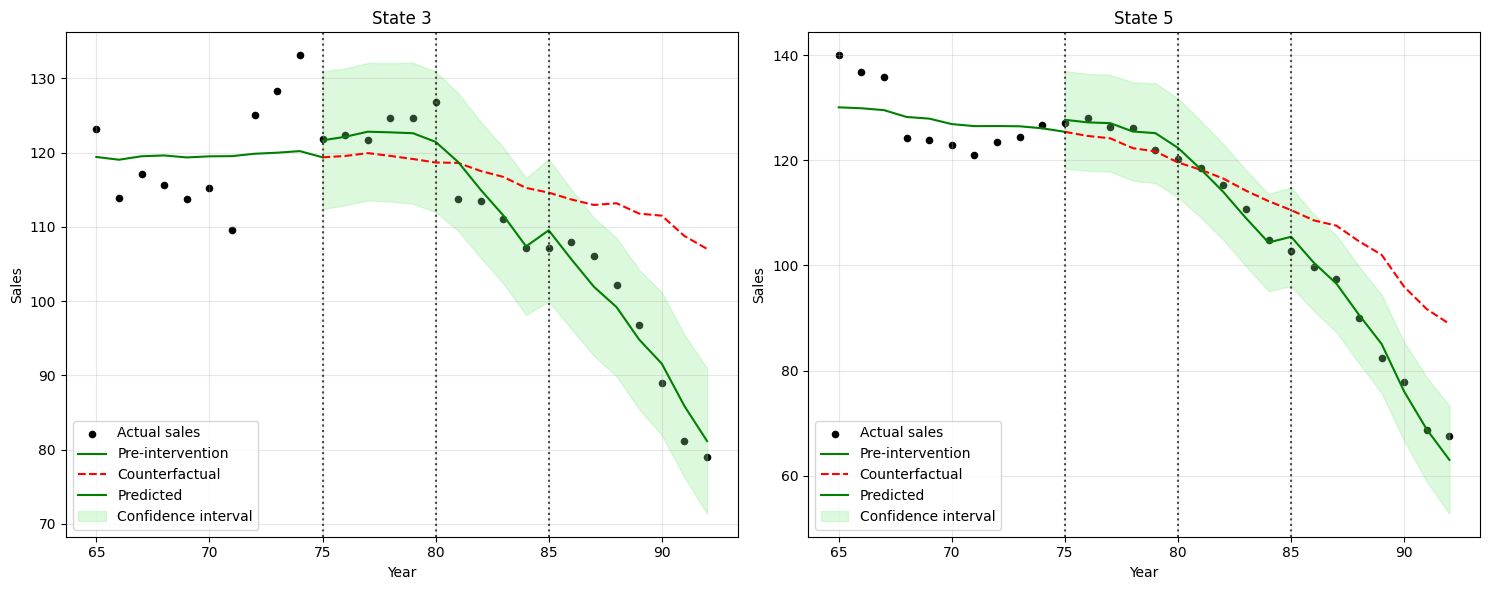

In [60]:
fig, axes = plt.subplots(len(state)//2 + len(state)%2, 2, figsize=(15, 6 * (len(state)//2 + len(state)%2)))

# Handle axes properly for different cases
if len(state) == 1:
  axes = [axes.flatten()[0]]  # Use only the first subplot
elif len(state) == 2:
  axes = axes.flatten()
else:
  axes = axes.flatten()

for i, s in enumerate(state):
  ax = axes[i]
  
  # データをフィルタリング
  data_state = cigar_plot[cigar_plot['state'] == s]
  
  # 1. salesを点グラフで描画
  ax.scatter(data_state['year'], data_state['sales'], color='black', s=20, label='Actual sales')
  
  # 2. y_counterfactualを赤い線グラフで描画（year=78以前は実線、以降は破線）
  pre_78 = data_state[data_state['year'] <= timestamp[0]]
  post_78 = data_state[data_state['year'] >= timestamp[0]]
  
  ax.plot(pre_78['year'], pre_78['y_counterfactual'], color='Green', linestyle='-', label='Pre-intervention')
  ax.plot(post_78['year'], post_78['y_counterfactual'], color='red', linestyle='--', label='Counterfactual')
  
  # 3. y_pred_meanを青い線グラフで描画、信頼区間を塗りつぶし
  ax.plot(
    data_state.loc[data_state['year']>=timestamp[0],'year'], 
    data_state.loc[data_state['year']>=timestamp[0],'y_pred_mean'], 
    color='green', label='Predicted')
  ax.fill_between(data_state.loc[data_state['year']>=timestamp[0],'year'],
          data_state.loc[data_state['year']>=timestamp[0],'y_pred_ci_lower'],
          data_state.loc[data_state['year']>=timestamp[0],'y_pred_ci_upper'],
      color='lightgreen', alpha=0.3, label='Confidence interval')
  
  # 4. timestampで縦線を引く
  for ts in timestamp:
    ax.axvline(x=ts, color='black', linestyle=':', alpha=0.7)
  
  ax.set_xlabel('Year')
  ax.set_ylabel('Sales')
  ax.set_title(f'State {s}')
  ax.legend()
  ax.grid(True, alpha=0.3)

# Hide unused subplots when len(state) is odd and > 1
if len(state) > 1 and len(state) % 2 == 1:
  axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

In [73]:
print(f'1975年施策のベース効果: {reg_res.params["D_1"]:.2f}')
print(f'1975年施策のトレンド効果: {reg_res.params["timedelta_1"]-reg_res.params['t']:.2f}')
print(f'1980年施策のベース効果: {reg_res.params["D_2"]:.2f}')
print(f'1980年施策のトレンド効果: {reg_res.params["timedelta_2"]-reg_res.params['t']:.2f}')
print(f'1985年施策のベース効果: {reg_res.params["D_3"]:.2f}')
print(f'1985年施策のトレンド効果: {reg_res.params["timedelta_3"]-reg_res.params['t']:.2f}')

1975年施策のベース効果: 1.99
1975年施策のトレンド効果: -0.18
1980年施策のベース効果: 5.44
1980年施策のトレンド効果: -3.14
1985年施策のベース効果: -2.11
1985年施策のトレンド効果: -3.45
